In [1]:
import os
from datetime import datetime

from classes.prices.AVPrice import AVPrice
from classes.datasets.Technical_Diffshift import Technical_Diffshift
from classes.traders.Binary_Trader import Binary_Trader
from classes.allocators.Mean_LERP import Mean_LERP

from datetime import datetime
from ta import add_all_ta_features
import pandas as pd
import requests
import math
import numpy as np
import time
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
import matplotlib.pyplot as plt
from statistics import mean

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn import svm
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde

import warnings
warnings.filterwarnings('ignore')

In [2]:
TECHNICAL_COLS = ['volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_mfi', 'volume_vpt',
       'volume_nvi', 'volume_vwap', 'volatility_atr', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
       'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'trend_stc', 'momentum_rsi',
       'momentum_stoch_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d',
       'momentum_tsi', 'momentum_uo', 'momentum_stoch',
       'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_kama',
       'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'others_dr', 'others_dlr', 'others_cr']

In [3]:
def GetCryptoPriceDF(symbol): 
    cols = ['open', 'high', 'low', 'close', 'volume']
    url = 'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol='+symbol+'&market=CNY&apikey='+AV_KEY
    print(url)
    r = requests.get(url)
    data = r.json()
    dic = data['Time Series (Digital Currency Daily)']
    df = pd.DataFrame.from_dict(dic, orient='index')
    df = df[['1a. open (CNY)', '2a. high (CNY)', '3a. low (CNY)', '4a. close (CNY)', '5. volume']]
    df = df.rename(columns={'1a. open (CNY)': 'open', '2a. high (CNY)': 'high', '3a. low (CNY)': 'low', '4a. close (CNY)': 'close', '5. volume':'volume'})
    df.index.name = 'date'
    df = df.sort_index(ascending = True)
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    return df

def SampleDataframe(df, date, no_samples):
    ind = df.index.get_loc(date)
    if ind-no_samples > 0:
        df = df.iloc[ind+1-no_samples:ind+1,:]
        return df
    return None

def TrainForDate(sampled_df, test_size, model, param_grid, pca_comps, no_its):
    data = sampled_df.to_numpy()
    features, label = data[:,:-1], data[:,-1]
    scaler = StandardScaler()
    scl_data = scaler.fit_transform(features)
    x, y = scl_data, label

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)

    #fit pca on train, transform test
    pca = PCA(n_components=pca_comps, random_state=42)
    x_train = pca.fit_transform(x_train)
    x_test = pca.transform(x_test)
    
    print('pca variance: ' + str(sum(pca.explained_variance_ratio_)))

    clf = GridSearchCV(model, param_grid, refit=True, scoring='neg_root_mean_squared_error')
    best_model = clf.fit(x_train, y_train) # model.fit(x_train,y_train)
    y_train_pred = best_model.predict(x_train)
    y_test_pred = best_model.predict(x_test)

    accuracy_test = accuracy_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    print('Params: ' + str(best_model.best_params_))
    PlotPredVsAct(y_test_pred, y_test, 'acc: ' + str(accuracy_test) + ', f1: ' + str(f1_test))
    
    return scaler, pca, best_model, f1_test
    
def PlotPredVsAct(pred, acts, title):
    plt.figure(figsize=(7, 2))
    plt.plot(pred, label = "predictions")
    plt.plot(acts, label = "actual")
    plt.legend(loc="upper left")
    
    plt.title(title)
    plt.show()
    
def PredictForDate(df, prev_price, date, scaler, pca, model):
    sampled_df = SampleDataframe(df, date, 1)
    data = sampled_df.to_numpy()
    x, y = data[:,:-1], data[:,-1]
    x = scaler.transform(x)
    x = pca.transform(x)
    y_pred = model.predict(x)
    return y_pred

def GenerateModelResults_OLD(df, base_prices, model_param_sets, pca_comps, no_its, no_samples, test_size, regression_range):
    model_sets_results = {}
    for key in model_param_sets:
        model_param_set = model_param_sets[key]
        #res_dict = {'date':[], 'open':[], 'close':[], 'prediction':[], 'test_mse':[]}
        res_dict = {'date':[], 'params':[], 'test_F1': [], 'prediction':[]}
        for i in regression_range:
            date = df.index[i]
            prev_date = df.index[i-1]
            open = base_prices.iloc[i]['open']
            close = base_prices.iloc[i]['close']

            sampled_df = SampleDataframe(df, prev_date, no_samples)
            scaler, pca, model, test_F1 = TrainForDate(sampled_df, test_size, model_param_set[0], model_param_set[1], pca_comps, no_its)
            prev_price = base_prices.iloc[i-1,-1]
            pred = PredictForDate(df, prev_price, date, scaler, pca, model)

            res_dict['date'].append(date)
            #res_dict['open'].append(open)
            #res_dict['close'].append(close)
            prediction = -1
            if pred[0] == 1:
                prediction = 1
            res_dict['params'].append(model.best_params)
            res_dict['test_F1'].append(test_F1)
            res_dict['prediction'].append(prediction)
            

        model_sets_results[key] = pd.DataFrame(res_dict)
    return model_sets_results

def GenerateModelResults(df, base_prices, model_param_set, pca_comps, no_its, no_samples, test_size, regression_range):
    res_dict = {'date':[], 'params':[], 'test_F1': [], 'prediction':[]}
    for i in regression_range:
        date = df.index[i]
        prev_date = df.index[i-1]

        sampled_df = SampleDataframe(df, prev_date, no_samples)
        scaler, pca, model, test_F1 = TrainForDate(sampled_df, test_size, model_param_set[0], model_param_set[1], pca_comps, no_its)
        prev_price = base_prices.iloc[i-1,-1]
        pred = PredictForDate(df, prev_price, date, scaler, pca, model)

        res_dict['date'].append(date)
        prediction = -1
        if pred[0] == 1:
            prediction = 1
        res_dict['params'].append(model.best_params_)
        res_dict['test_F1'].append(test_F1)
        res_dict['prediction'].append(prediction)

    return pd.DataFrame(res_dict)

def GeneratePredictorResultsOLD(df, base_prices,predictors,model_sets_results, run_range, rolls=[5,10,20]):
    predictors_results = {}
    for pred_key in predictors:
        res_dict = {'date':[],'open':[], 'close':[], 'high':[], 'low':[], 'agg_prediction':[], 'bet_dir':[], 'exit_price':[], 'act_perc_pal':[]}
        x = 0
        for i in run_range:
            date = df.index[i]
            open = base_prices.iloc[i]['open']
            close = base_prices.iloc[i]['close']
            high = base_prices.iloc[i]['high']
            low = base_prices.iloc[i]['low']

            predictor = predictors[pred_key]
            res_dict['date'].append(date)
            res_dict['open'].append(open)
            res_dict['close'].append(close)
            res_dict['high'].append(high)
            res_dict['low'].append(low)
            agg_pred = predictor.get_agg_prediction(x,model_sets_results)
            res_dict['agg_prediction'].append(agg_pred)
            res_dict['bet_dir'].append(predictor.bet_dir(agg_pred))
            res_dict['exit_price'].append(predictor.exit_at(agg_pred, open, close, high, low))
            res_dict['act_perc_pal'].append(predictor.percent_pal(agg_pred, open, close, high, low))
            x+=1

        metrics = pd.DataFrame(res_dict)
        for roll in rolls:
            metrics[str(roll) + 'D_mean'] = metrics['act_perc_pal'].rolling(roll).mean()
            metrics[str(roll) + 'D_cumprod'] = (1 + metrics['act_perc_pal']).rolling(roll).apply(np.prod, raw=True) - 1
        predictors_results[pred_key] = metrics
    return predictors_results

def GeneratePredictorResults(df, base_prices, predictor, model_results, run_range, norm_price):
    res_dict = {'date':[],'bought_at':[], 'prediction':[], 'sold_at':[], 'perc_pal':[]}
    x = 0
    for i in run_range:
        date = df.index[i]
        open = base_prices.iloc[i]['open']
        close = base_prices.iloc[i]['close']
        high = base_prices.iloc[i]['high']
        low = base_prices.iloc[i]['low']
        if norm_price:
            open = base_prices.iloc[i]['norm_open']
            close = base_prices.iloc[i]['norm_close']
            high = base_prices.iloc[i]['norm_high']
            low = base_prices.iloc[i]['norm_low']

        prediction = predictor.get_prediction(x, model_results)
        res_dict['date'].append(date)
        res_dict['bought_at'].append(open)
        res_dict['prediction'].append(prediction)
        res_dict['sold_at'].append(predictor.exit_at(prediction, open, close, high, low))
        res_dict['perc_pal'].append(predictor.percent_pal(prediction, open, close, high, low))
        x+=1

    return pd.DataFrame(res_dict)

def PlotPredictorResults(PredictorName, PredictorResults):
    fig, axs = plt.subplots(2,2, figsize=(12,6))
    axs[0, 0].set_title('rolling means')
    axs[0, 1].set_title('cumulative prods')
    
    for roll in [5,10,20]:
        mean_data = PredictorResults[str(roll) + 'D_mean'].dropna()
        sns.lineplot(data = PredictorResults, x = 'date', y = str(roll) + 'D_mean' , ax=axs[1,0])
        sns.kdeplot(mean_data,bw=0.25,ax=axs[0,0])

        cump_data = PredictorResults[str(roll) + 'D_cumprod'].dropna()
        sns.lineplot(data = PredictorResults, x = 'date', y = str(roll) + 'D_cumprod' , ax=axs[1,1])
        sns.kdeplot(cump_data,bw=0.25,ax=axs[0,1])
        
        if roll == 20:
            print(PredictorName + ', average 20D mean: ' + str(mean_data.mean()) + ', average 20 cumprod: ' + str(cump_data.mean()))
    plt.show()

#allocator============================================================================
def GeneratePortfolioReturns(portfolio_result, rolls = [3, 5]):
    df = portfolio_result[['date','weight','weighted_pal']]
    df = df.groupby(['date']).sum().reset_index()
    for roll in rolls:
        df[str(roll) + 'D_mean'] = df['weighted_pal'].rolling(roll).mean()
        df[str(roll) + 'D_cumprod'] = (1 + df['weighted_pal']).rolling(roll).apply(np.prod, raw=True) - 1
    return df

def GenerateInstructions(date, portfolio_result):
    df = portfolio_result[(portfolio_result['date'] == date)]
    df = df[['date','symbol','exit_method','bought_at','amount']]
    df = df.groupby(['date','symbol','exit_method','bought_at']).sum().reset_index()
    return df

#classifier====================================================================
def GetClassifierDatasetRunRange(start_date, end_date, dataset, classifier_data):
    run_ranges = []
    try:
        start_ind, end_ind = dataset.index.get_loc(start_date), dataset.index.get_loc(end_date)
    except:
        print('dates not found in underlying dataset, aborting generating classifier data')
        return
    if start_ind > end_ind:
        print('start_date is not earlier than end date, aborting generating classifier data')
    elif len(classifier_data) == 0:
        print('no file, running for full range: ' + start_date + ' - ' + end_date)
        run_ranges.append(range(start_ind, end_ind))
    else:
        existing_data = classifier_data[0]
        existing_sdate, existing_edate = existing_data['date'][0], existing_data['date'].iloc[-1]
        existing_start_ind, existing_end_ind = dataset.index.get_loc(existing_sdate), dataset.index.get_loc(existing_edate)
        if end_ind <= existing_end_ind and start_ind >= existing_start_ind:
            print('date range exists fully in file, not running any range')
        elif end_ind < existing_start_ind:
            print('existing file starts after specified end date - running up to start of file: ' + start_date + ' -> ' + existing_sdate)
            run_ranges.append(range(start_ind, existing_start_ind))
        elif start_ind > existing_end_ind:
            print('existing file ends before specified start date - running from end of file: ' + existing_edate + ' -> ' + end_date)
            run_ranges.append(range(existing_end_ind, end_ind))
        else: 
            if start_ind < existing_start_ind:
                print('running up to start of file: ' + start_date + ' -> ' + existing_sdate)
                run_ranges.append(range(start_ind, existing_start_ind))
            if end_ind > existing_end_ind:
                print('running from end of file: ' + existing_edate + ' -> ' + end_date)
                run_ranges.append(range(existing_end_ind, end_ind))
    return run_ranges  

def CheckKeys(Debug, included, excluded, price='',dataset='',classifier='',trader='',allocator=''):
    if price != '' and 'prices' in included and len(included['prices']) > 0 and price not in included['prices']:
        if Debug: print('price: ' + price + ' not in included: ' + str(included['prices']))
        return False
    if dataset != '' and 'datasets' in included and len(included['datasets']) > 0 and dataset not in included['datasets']:
        if Debug: print('dataset: ' + dataset + ' not in included: ' + str(included['datasets']))
        return False
    if classifier != '' and 'classifiers' in included and len(included['classifiers']) > 0 and classifier not in included['classifiers']:
        if Debug: print('classifier: ' + classifier + ' not in included: ' + str(included['classifiers']))
        return False
    if trader != '' and 'traders' in included and len(included['traders']) > 0 and trader not in included['traders']:
        if Debug: print('trader: ' + trader + ' not in included: ' + str(included['traders']))
        return False
    if allocator != '' and 'allocators' in included and len(included['allocators']) > 0 and allocator not in included['allocators']:
        if Debug: print('allocator: ' + allocator + ' not in included: ' + str(included['allocators']))
        return False
    
    if price != '' and 'prices' in excluded and len(excluded['prices']>0) and price in excluded['prices']:
        if Debug: print('price: ' + price + ' in excluded: ' + str(excluded['prices']))
        return False
    if dataset != '' and 'datasets' in excluded and len(excluded['datasets']) > 0 and dataset in excluded['datasets']:
        if Debug: print('dataset: ' + dataset + ' in included: ' + str(excluded['datasets']))
        return False
    if classifier != '' and 'classifiers' in excluded and len(excluded['classifiers']) > 0 and classifier in excluded['classifiers']:
        if Debug: print('classifier: ' + classifier + ' in excluded: ' + str(excluded['classifiers']))
        return False
    if trader != '' and 'traders' in excluded and len(excluded['traders']) > 0 and trader in excluded['traders']:
        if Debug: print('trader: ' + trader + ' in excluded: ' + str(excluded['traders']))
        return False
    if allocator != '' and 'allocators' in excluded and len(excluded['allocators']) > 0 and allocator in excluded['allocators']:
        if Debug: print('allocator: ' + allocator + ' in excluded: ' + str(excluded['allocators']))
        return False
    
    return True


<h1>Model Definitions</h1>

In [4]:
prices = {'500.PAR': AVPrice('500.PAR'),
          'NDAQ': AVPrice('NDAQ'),
          'DAX': AVPrice('DAX'),
          'AAPL': AVPrice('AAPL'),
          'MSFT': AVPrice('MSFT'),
          'AMZN': AVPrice('AMZN'),
          'FB': AVPrice('FB'),
          'GOOGL': AVPrice('GOOGL'),
          'GOOG': AVPrice('GOOG'),
          'TSLA': AVPrice('TSLA'),
          'NVDA': AVPrice('NVDA')}

datasets = {'500.PAR':Technical_Diffshift(label='500.PAR', 
                              symbols=['500.PAR','NDAQ','DAX','AAPL','MSFT','AMZN','FB','GOOGL','GOOG'], 
                              pivot_cols = ['open','high','low','close','volume'], 
                              pivots = {1:[1,2,3,4,5,6,7,8,9,10],10:[10,20,30]},
                              technical_cols = ['volume_adi'],
                              included = {'prices':['500.PAR']}),
           'NDAQ':Technical_Diffshift(label='NDAQ', 
                              symbols=['500.PAR','NDAQ','DAX','AAPL','MSFT','AMZN','FB','GOOGL','GOOG'], 
                              pivot_cols = ['open','high','low','close','volume'], 
                              pivots = {1:[1,2,3,4,5,6,7,8,9,10],10:[10,20,30]},
                              technical_cols = ['volume_adi'],
                              included = {'prices':['NDAQ']})}

classifiers = {'M1': (MLPClassifier(random_state=42), {'hidden_layer_sizes':[(56,28),(28,14),(64,32,16)], 'max_iter':[100,200], 'activation':['relu'], 'solver':['adam'], 'learning_rate_init':[0.001,0.01]})}#,
                #'M2': (SVC(gamma=2),{'C':[0.025,0.25,1]}),
                #'M3': (DecisionTreeClassifier(),{'max_depth':[5,10]}),
                #'M4': (RandomForestClassifier(),{'max_depth':[5,10], 'n_estimators':[5,10],'max_features':[1]})}

predictors = {'P1': Binary_Trader(threshold=0.0025, exit_method='at_close'),
             'P2': Binary_Trader(threshold=0.0025, exit_method='capture_gains', capture_thresh = 0.0075),
             'P3': Binary_Trader(threshold=0.0025, exit_method='at_close', trade_longs = False, tags=['shortonly']),
             'P4': Binary_Trader(threshold=0.0025, exit_method='capture_gains', capture_thresh = 0.0075, trade_longs = False, tags=['shortonly'])}

allocators = {'A1': Mean_LERP(mean_periods = 5, min_lerp = 0.25, max_lerp = 1),
             'A2': Mean_LERP(mean_periods = 5, min_lerp = 0.25, max_lerp = 1, include_tags = ['shortonly'])}

In [24]:
import pandas as pd
import plotly.graph_objects as go
df = pd.read_csv("https://raw.githubusercontent.com/bcdunbar/datasets/master/parcoords_data.csv")

fig = go.Figure(data=
    go.Parcoords(
        line = dict(
                   colorscale = 'Electric',
                   showscale = True,
                   cmin = -4000,
                   cmax = -100),
        dimensions = list([
            dict(
                 constraintrange = [100000,150000],
                 label = "Block Height", values = df['blockHeight']),
            dict(
                 label = 'Block Width', values = df['blockWidth']),
            dict(tickvals = [0,0.5,1,2,3],
                 ticktext = ['A','AB','B','Y','Z'],
                 label = 'Cyclinder Material', values = df['cycMaterial']),
            dict(
                 tickvals = [0,1,2,3],
                 label = 'Block Material', values = df['blockMaterial']),
            dict(
                 label = 'Total Weight', values = df['totalWeight']),
            dict(
                 label = 'Assembly Penalty Wt', values = df['assemblyPW']),
            dict(
                 label = 'Height st Width', values = df['HstW'])])
    )
)
fig.show()

In [40]:
d = {'prices':['A','A','A','A','B','B','B','B'],'datasets':['X','X','Y','Y','X','X','Y','Y'],'classifiers':['1','2','1','2','1','2','1','2']}

items = []
for item in d:
    if item in ['prices','datasets','classifiers','traders','allocators']:
        ticktext = list(np.unique(np.array((d[item]))))
        tickvals = list(range(0,len(ticktext)))
        values = []
        for p in d[item]:
            values.append(ticktext.index(p))
        items.append({'tickvals':tickvals,'label':item,'ticktext':ticktext, 'values':values})

fig = go.Figure(data= go.Parcoords(line = dict(colorscale = 'Electric'), dimensions = items))
fig.show()

<h1>Run Parameters</h1>

In [5]:
runid = '20220212'

start_date, end_date = '2021-06-01', '2021-09-30'

#prices ignore start date - NOT IMPLEMENTED
price_load_mode = 'file_or_generate' #'file', 'generate', 'file_or_generate'
price_save_rslt = False

#datasets ignore start date - NOT IMPLEMENTED
dataset_load_mode = 'file' #'file', 'generate', 'file_or_generate'
dataset_save_rslt = False

#use start and end date
classifier_load_mode = 'file_or_generate' #'file', 'generate', 'file_or_generate'
classifier_save_rslt = True

#use start and end date
trader_load_mode = 'generate' #'file', 'generate'
trader_save_rslt = False

allocator_load_mode = 'generate' #'file', 'generate'
allocator_save_rslt = True

<h1> Prices </h1>

In [6]:
price_data = {}
for p in prices:
    if price_load_mode == 'file':
        print('loading price: ' + p)
        price_data[p] = pd.read_csv('prices\\' + p + '.csv', index_col = 'date')
    elif price_load_mode == 'generate':
        print('downloading price: ' + p)
        price_data[p] = prices2[p].CreatePriceData()      
    elif price_load_mode == 'file_or_generate':
        print('loading or downloading price: ' + p)
        price_df = pd.read_csv('prices\\' + p + '.csv', index_col = 'date')
        ls_dtstr_in_file = price_df.index[-1]
        ls_dt_in_file = datetime.strptime(ls_dtstr_in_file, '%Y-%m-%d').date()
        edt = datetime.strptime(end_date, '%Y-%m-%d').date()
        if edt > ls_dt_in_file:
            print('required date is greater than last date in file: ' + ls_dtstr_in_file + ' < ' + end_date)
            price_data[p] = prices2[p].CreatePriceData()
        else:
            print('file is up to date: ' + ls_dtstr_in_file + ' >= ' + end_date)
            price_data[p] = pd.read_csv('prices\\' + p + '.csv', index_col = 'date')
    
    if price_save_rslt and price_load_mode != 'file':
         price_data[p].to_csv('prices\\' + p + '.csv', index=True)  

loading or downloading price: 500.PAR
file is up to date: 2022-02-11 >= 2021-09-30
loading or downloading price: NDAQ
file is up to date: 2022-02-11 >= 2021-09-30
loading or downloading price: DAX
file is up to date: 2022-02-11 >= 2021-09-30
loading or downloading price: AAPL
file is up to date: 2022-02-11 >= 2021-09-30
loading or downloading price: MSFT
file is up to date: 2022-02-11 >= 2021-09-30
loading or downloading price: AMZN
file is up to date: 2022-02-11 >= 2021-09-30
loading or downloading price: FB
file is up to date: 2022-02-11 >= 2021-09-30
loading or downloading price: GOOGL
file is up to date: 2022-02-11 >= 2021-09-30
loading or downloading price: GOOG
file is up to date: 2022-02-11 >= 2021-09-30
loading or downloading price: TSLA
file is up to date: 2022-02-11 >= 2021-09-30
loading or downloading price: NVDA
file is up to date: 2022-02-11 >= 2021-09-30


In [7]:
print(price_data['500.PAR'].shape)
print(price_data['500.PAR'].tail())

(3016, 13)
               open     high      low    close  volume  open_1D_diff_perc  \
date                                                                        
2022-02-07  74.3731  74.5863  73.8862  74.1579    7822          -0.002939   
2022-02-08  74.2349  74.5648  73.8901  74.5648   10114          -0.001858   
2022-02-09  74.9191  75.5556  74.9191  75.4897    7360           0.009217   
2022-02-10  75.7833  75.7833  74.8639  74.8639    5834           0.011535   
2022-02-11  74.4168  74.9084  74.1498  74.3300  850950          -0.018032   

            open_1D_diff_perc_20D_STD  target_STD  leverage   norm_open  \
date                                                                      
2022-02-07                   0.010279       0.015  1.459332  108.535053   
2022-02-08                   0.010278       0.015  1.459419  108.339820   
2022-02-09                   0.010356       0.015  1.448476  108.518517   
2022-02-10                   0.010601       0.015  1.414956  107.230000   

<h1>Datasets </h1>

In [24]:
read_dataset_data = True

dataset_results = {}
for p in prices:
    for d in datasets:
        if not CheckKeys(False, datasets[d].included, datasets[d].excluded, p):
            continue
        print('loading price: ' + p + ', dataset: ' + d)
        
        if read_dataset_data:
            dataset_results[d] = pd.read_csv('output\\' + runid + '\\datasets\\' + d + '.csv', index_col = 'date')
        else:
            print('creating dataset for: ' + d)
            dataset_results[d] = datasets[d].CreateDataset(price_data)
            dataset_results[d].to_csv('output\\' + runid + '\\datasets\\' + d + '.csv', index=True)  
    
for d in datasets: #make sure base price data is only as long as it's dataset
    price_data[d] = price_data[d][price_data[d].index.isin(dataset_results[d].index)] 

loading price: 500.PAR, dataset: 500.PAR
loading price: NDAQ, dataset: NDAQ


In [25]:
print(dataset_results['500.PAR'].shape)
print(dataset_results['NDAQ'].shape)

(1827, 604)
(1827, 604)


<h1>Classifiers</h1>
<p>classifiers generate signals for each of the datesets</p>

In [26]:
#classifier training parameters
pca_comps = 150
no_samples = 400
test_size = 0.33

In [27]:
dataset_classifier_results = {}
for d in datasets: 
    classifier_results = {}
    base_prices = price_data[datasets[d].label]
    df = dataset_results[d]
    for c in classifiers:
        #if not CheckKeys(False, classifiers[c].included, classifiers[c].excluded, '', d):
        #    continue
        if classifier_load_mode == 'file':
            print('loading classifier data for: ' + d + ', ' + c)
            classifier_results[c] = pd.read_csv('output\\' + runid + '\\classifiers\\' + d + '_' + c + '.csv')
        elif classifier_load_mode == 'generate':
            print('generating classifier data for: ' + d + ', ' + c)
            classifier = classifiers[c] 
            start_ind, end_ind = df.index.get_loc(start_date), df.index.get_loc(end_date) + 1
            classifier_results[c] = GenerateModelResults(df, base_prices, classifier, pca_comps, 1, no_samples, test_size, range(start_ind, end_ind)) 
        elif classifier_load_mode == 'file_or_generate':
            print('loading or generating classifier data for: ' + d + ', ' + c)
            classifier, classifier_data = classifiers[c], []
            if os.path.exists('output\\' + runid + '\\classifiers\\' + d + '_' + c + '.csv'):
                classifier_data.append(pd.read_csv('output\\' + runid + '\\classifiers\\' + d + '_' + c + '.csv'))
            for run_range in GetClassifierDatasetRunRange(start_date, end_date, df, classifier_data):
                classifier_data.append(GenerateModelResults(df, base_prices, classifier, pca_comps, 1, no_samples, test_size, run_range))
            classifier_results[c] = pd.concat(classifier_data)
            classifier_results[c].sort_values(['date'], inplace=True)
        
        if classifier_save_rslt and classifier_load_mode != 'file':
            classifier_results[c].to_csv('output\\' + runid + '\\classifiers\\' + d + '_' + c + '.csv', index=False)    
                
    dataset_classifier_results[d] = classifier_results

loading or generating classifier data for: 500.PAR, M1
date range exists fully in file, not running any range
loading or generating classifier data for: NDAQ, M1
date range exists fully in file, not running any range


In [28]:
dataset_classifier_results['500.PAR']['M1']

date                                             params   test_F1  \
0   2021-06-01  {'activation': 'relu', 'hidden_layer_sizes': (...  0.519598   
1   2021-06-02  {'activation': 'relu', 'hidden_layer_sizes': (...  0.508964   
2   2021-06-03  {'activation': 'relu', 'hidden_layer_sizes': (...  0.604971   
3   2021-06-04  {'activation': 'relu', 'hidden_layer_sizes': (...  0.459304   
4   2021-06-07  {'activation': 'relu', 'hidden_layer_sizes': (...  0.548623   
..         ...                                                ...       ...   
81  2021-09-24  {'activation': 'relu', 'hidden_layer_sizes': (...  0.519507   
82  2021-09-27  {'activation': 'relu', 'hidden_layer_sizes': (...  0.516595   
83  2021-09-28  {'activation': 'relu', 'hidden_layer_sizes': (...  0.447446   
84  2021-09-29  {'activation': 'relu', 'hidden_layer_sizes': (...  0.423184   
85  2021-09-30  {'activation': 'relu', 'hidden_layer_sizes': (...  0.478083   

    prediction  
0           -1  
1           -1  
2            1  
3            1  
4            1  
..         ...  
81          -1  
82           1  
83           1  
84           1  
85           1  

[86 rows x 4 columns]

In [29]:
dataset_classifier_results['NDAQ']['M1']

date                                             params   test_F1  \
0   2021-06-01  {'activation': 'relu', 'hidden_layer_sizes': (...  0.483899   
1   2021-06-02  {'activation': 'relu', 'hidden_layer_sizes': (...  0.529979   
2   2021-06-03  {'activation': 'relu', 'hidden_layer_sizes': (...  0.539336   
3   2021-06-04  {'activation': 'relu', 'hidden_layer_sizes': (...  0.568663   
4   2021-06-07  {'activation': 'relu', 'hidden_layer_sizes': (...  0.559574   
..         ...                                                ...       ...   
81  2021-09-24  {'activation': 'relu', 'hidden_layer_sizes': (...  0.519507   
82  2021-09-27  {'activation': 'relu', 'hidden_layer_sizes': (...  0.516595   
83  2021-09-28  {'activation': 'relu', 'hidden_layer_sizes': (...  0.447446   
84  2021-09-29  {'activation': 'relu', 'hidden_layer_sizes': (...  0.423184   
85  2021-09-30  {'activation': 'relu', 'hidden_layer_sizes': (...  0.478083   

    prediction  
0           -1  
1            1  
2            1  
3           -1  
4           -1  
..         ...  
81          -1  
82           1  
83           1  
84           1  
85           1  

[86 rows x 4 columns]

<h1>Trader</h1>
<p>Every trader definition is generated for every classifier. They convert classifier signals to a normalised daily return using sell-off rules</p>

In [30]:
norm_price = True

In [31]:
dataset_classifier_predictor_results = {}
for d in datasets:
    classifier_predictor_results = {}
    base_prices = price_data[datasets[d].label]
    df  = dataset_results[d]
    for c in classifiers:
        predictor_results = {}
        classifier_results = dataset_classifier_results[d][c]
        for p in predictors:
            if not CheckKeys(False, predictors[p].included, predictors[p].excluded, '', d, c):
                continue
            if trader_load_mode == 'file':
                print('loading trader data for: ' + d + ', ' + c + ', ' + p)
                predictor_results[p] = pd.read_csv('output\\' + runid + '\\traders\\' + d + '_' + c + '_' + p + '.csv')
            elif trader_load_mode == 'generate':
                print('generating trader data: ' + d + ', ' + c + ', ' + p)
                start_ind, end_ind = df.index.get_loc(start_date), df.index.get_loc(end_date)+1
                predictor_results[p] = GeneratePredictorResults(df, base_prices, predictors[p], classifier_results, range(start_ind, end_ind), norm_price)
            if trader_save_rslt:
                predictor_results[p].to_csv('output\\' + runid + '\\traders\\' + d + '_' + c + '_' + p + '.csv', index=False)
        classifier_predictor_results[c] = predictor_results
    dataset_classifier_predictor_results[d] = classifier_predictor_results

generating trader data: 500.PAR, M1, P1
generating trader data: 500.PAR, M1, P2
generating trader data: 500.PAR, M1, P3
generating trader data: 500.PAR, M1, P4
generating trader data: NDAQ, M1, P1
generating trader data: NDAQ, M1, P2
generating trader data: NDAQ, M1, P3
generating trader data: NDAQ, M1, P4


In [33]:
dataset_classifier_predictor_results['500.PAR']['M1']['P1']

date   bought_at  prediction     sold_at  perc_pal
0   2021-06-01  106.223581          -1  106.020702  0.001910
1   2021-06-02  106.191609          -1  106.460614 -0.002533
2   2021-06-03  106.151038           1  106.464631  0.002954
3   2021-06-04  106.499370           1  106.683669  0.001731
4   2021-06-07  106.412724           1  105.880663 -0.005000
..         ...         ...         ...         ...       ...
81  2021-09-24  175.527845          -1  176.083829 -0.003167
82  2021-09-27  164.967801           1  164.043256 -0.005604
83  2021-09-28  160.462322           1  157.901364 -0.015960
84  2021-09-29  146.814832           1  147.702730  0.006048
85  2021-09-30  139.909990           1  138.742009 -0.008348

[86 rows x 5 columns]

In [34]:
dataset_classifier_predictor_results['500.PAR']['M1']['P2']

date   bought_at  prediction     sold_at  perc_pal
0   2021-06-01  106.223581          -1  106.020702  0.001910
1   2021-06-02  106.191609          -1  106.460614 -0.002533
2   2021-06-03  106.151038           1  106.464631  0.002954
3   2021-06-04  106.499370           1  106.683669  0.001731
4   2021-06-07  106.412724           1  105.880663 -0.005000
..         ...         ...         ...         ...       ...
81  2021-09-24  175.527845          -1  176.083829 -0.003167
82  2021-09-27  164.967801           1  164.043256 -0.005604
83  2021-09-28  160.462322           1  157.901364 -0.015960
84  2021-09-29  146.814832           1  147.915944  0.007500
85  2021-09-30  139.909990           1  138.742009 -0.008348

[86 rows x 5 columns]

In [35]:
dataset_classifier_predictor_results['500.PAR']['M1']['P3']

date   bought_at  prediction     sold_at  perc_pal
0   2021-06-01  106.223581          -1  106.020702  0.001910
1   2021-06-02  106.191609          -1  106.460614 -0.002533
2   2021-06-03  106.151038           0  106.464631  0.000000
3   2021-06-04  106.499370           0  106.683669  0.000000
4   2021-06-07  106.412724           0  105.880663  0.000000
..         ...         ...         ...         ...       ...
81  2021-09-24  175.527845          -1  176.083829 -0.003167
82  2021-09-27  164.967801           0  164.043256  0.000000
83  2021-09-28  160.462322           0  157.901364  0.000000
84  2021-09-29  146.814832           0  147.702730  0.000000
85  2021-09-30  139.909990           0  138.742009  0.000000

[86 rows x 5 columns]

In [36]:
dataset_classifier_predictor_results['500.PAR']['M1']['P4']

date   bought_at  prediction     sold_at  perc_pal
0   2021-06-01  106.223581          -1  106.020702  0.001910
1   2021-06-02  106.191609          -1  106.460614 -0.002533
2   2021-06-03  106.151038           0  106.464631  0.000000
3   2021-06-04  106.499370           0  106.683669  0.000000
4   2021-06-07  106.412724           0  105.880663  0.000000
..         ...         ...         ...         ...       ...
81  2021-09-24  175.527845          -1  176.083829 -0.003167
82  2021-09-27  164.967801           0  164.043256  0.000000
83  2021-09-28  160.462322           0  157.901364  0.000000
84  2021-09-29  146.814832           0  147.702730  0.000000
85  2021-09-30  139.909990           0  138.742009  0.000000

[86 rows x 5 columns]

<h1>Allocators</h1>
<p>Allocators take all the traders and score them then allocate to them based on previous days score</p>

In [37]:
allocator_results, allocator_returns = {}, {}
for a in allocators:
    if allocator_load_mode == 'file':
        print('loading allocator data for: ' + a)
        allocator_results[a] = pd.read_csv('output\\' + runid + '\\allocators\\' + a + '.csv')
    elif allocator_load_mode == 'generate':
        print('generating allocator data for: ' + a)
        allocator_results[a] = allocators[a].GeneratePortfolioResults(dataset_classifier_predictor_results, predictors)
        
    if allocator_save_rslt:
        allocator_results[a].to_csv('output\\' + runid + '\\allocators\\'  + a + '.csv', index=False)
    allocator_returns[a] = GeneratePortfolioReturns(allocator_results[a])

generating allocator data for: A1
generating allocator data for: A2


In [38]:
allocator_results['A1'][(allocator_results['A1']['date']=='2021-09-24')]

date   symbol classifier predictor    exit_method   bought_at  \
81  2021-09-24  500.PAR         M1        P1       at_close  175.527845   
81  2021-09-24  500.PAR         M1        P2  capture_gains  175.527845   
81  2021-09-24  500.PAR         M1        P3       at_close  175.527845   
81  2021-09-24  500.PAR         M1        P4  capture_gains  175.527845   
81  2021-09-24     NDAQ         M1        P1       at_close  270.577928   
81  2021-09-24     NDAQ         M1        P2  capture_gains  270.577928   
81  2021-09-24     NDAQ         M1        P3       at_close  270.577928   
81  2021-09-24     NDAQ         M1        P4  capture_gains  270.577928   

    prediction  5D_mean_pal_S1      lerp    weight    amount     sold_at  \
81          -1        0.001580  0.784130  0.130587 -0.130587  176.083829   
81          -1        0.002116  1.000000  0.166538 -0.166538  176.083829   
81          -1        0.001580  0.784130  0.130587 -0.130587  176.083829   
81          -1        0.002116  1.000000  0.166538 -0.166538  176.083829   
81          -1        0.000254  0.250000  0.041634 -0.041634  273.173899   
81          -1        0.002037  0.968194  0.161241 -0.161241  273.173899   
81          -1        0.000254  0.250000  0.041634 -0.041634  273.173899   
81          -1        0.002037  0.968194  0.161241 -0.161241  273.173899   

    perc_pal  weighted_pal  
81 -0.003167     -0.000414  
81 -0.003167     -0.000528  
81 -0.003167     -0.000414  
81 -0.003167     -0.000528  
81 -0.009594     -0.000399  
81 -0.009594     -0.001547  
81 -0.009594     -0.000399  
81 -0.009594     -0.001547

In [39]:
allocator_results['A2'][(allocator_results['A2']['date']=='2021-09-24')]

date   symbol classifier predictor    exit_method   bought_at  \
81  2021-09-24  500.PAR         M1        P3       at_close  175.527845   
81  2021-09-24  500.PAR         M1        P4  capture_gains  175.527845   
81  2021-09-24     NDAQ         M1        P3       at_close  270.577928   
81  2021-09-24     NDAQ         M1        P4  capture_gains  270.577928   

    prediction  5D_mean_pal_S1      lerp    weight    amount     sold_at  \
81          -1        0.001580  0.784130  0.261174 -0.261174  176.083829   
81          -1        0.002116  1.000000  0.333075 -0.333075  176.083829   
81          -1        0.000254  0.250000  0.083269 -0.083269  273.173899   
81          -1        0.002037  0.968194  0.322482 -0.322482  273.173899   

    perc_pal  weighted_pal  
81 -0.003167     -0.000827  
81 -0.003167     -0.001055  
81 -0.009594     -0.000799  
81 -0.009594     -0.003094

In [23]:
allocator_returns['A1']

date  weight  weighted_pal   3D_mean  3D_cumprod   5D_mean  \
0   2021-06-01     0.0      0.000000       NaN         NaN       NaN   
1   2021-06-02     0.0      0.000000       NaN         NaN       NaN   
2   2021-06-03     0.0      0.000000  0.000000    0.000000       NaN   
3   2021-06-04     0.0      0.000000  0.000000    0.000000       NaN   
4   2021-06-07     0.0      0.000000  0.000000    0.000000  0.000000   
..         ...     ...           ...       ...         ...       ...   
81  2021-09-24     1.0     -0.005775 -0.004534   -0.013544 -0.001712   
82  2021-09-27     1.0     -0.002586 -0.004539   -0.013558 -0.002469   
83  2021-09-28     1.0     -0.006371 -0.004911   -0.014664 -0.004512   
84  2021-09-29     1.0      0.002417 -0.002180   -0.006545 -0.003514   
85  2021-09-30     1.0     -0.001395 -0.001783   -0.005359 -0.002742   

    5D_cumprod  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4     0.000000  
..         ...  
81   -0.008564  
82   -0.012314  
83   -0.022363  
84   -0.017474  
85   -0.013660  

[86 rows x 7 columns]

In [24]:
allocator_returns['A2']

date  weight  weighted_pal   3D_mean  3D_cumprod   5D_mean  \
0   2021-06-01     0.0      0.000000       NaN         NaN       NaN   
1   2021-06-02     0.0      0.000000       NaN         NaN       NaN   
2   2021-06-03     0.0      0.000000  0.000000    0.000000       NaN   
3   2021-06-04     0.0      0.000000  0.000000    0.000000       NaN   
4   2021-06-07     0.0      0.000000  0.000000    0.000000  0.000000   
..         ...     ...           ...       ...         ...       ...   
81  2021-09-24     1.0     -0.005775 -0.004736   -0.014142 -0.001609   
82  2021-09-27     1.0      0.000000 -0.003677   -0.011001 -0.002063   
83  2021-09-28     1.0      0.000000 -0.001925   -0.005775 -0.002841   
84  2021-09-29     1.0      0.000000  0.000000    0.000000 -0.002206   
85  2021-09-30     1.0      0.000000  0.000000    0.000000 -0.001155   

    5D_cumprod  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4     0.000000  
..         ...  
81   -0.008057  
82   -0.010305  
83   -0.014142  
84   -0.011001  
85   -0.005775  

[86 rows x 7 columns]

In [25]:
GenerateInstructions('2021-09-24', allocator_results['A1'])

date   symbol    exit_method   bought_at    amount
0  2021-09-24  500.PAR       at_close  175.527845 -0.261174
1  2021-09-24  500.PAR  capture_gains  175.527845 -0.333075
2  2021-09-24     NDAQ       at_close  270.577928 -0.083269
3  2021-09-24     NDAQ  capture_gains  270.577928 -0.322482

In [26]:
GenerateInstructions('2021-09-24', allocator_results['A2'])

date   symbol    exit_method   bought_at    amount
0  2021-09-24  500.PAR       at_close  175.527845 -0.261174
1  2021-09-24  500.PAR  capture_gains  175.527845 -0.333075
2  2021-09-24     NDAQ       at_close  270.577928 -0.083269
3  2021-09-24     NDAQ  capture_gains  270.577928 -0.322482

<h1>Reports</h1>

allocator: A1


allocator: A2


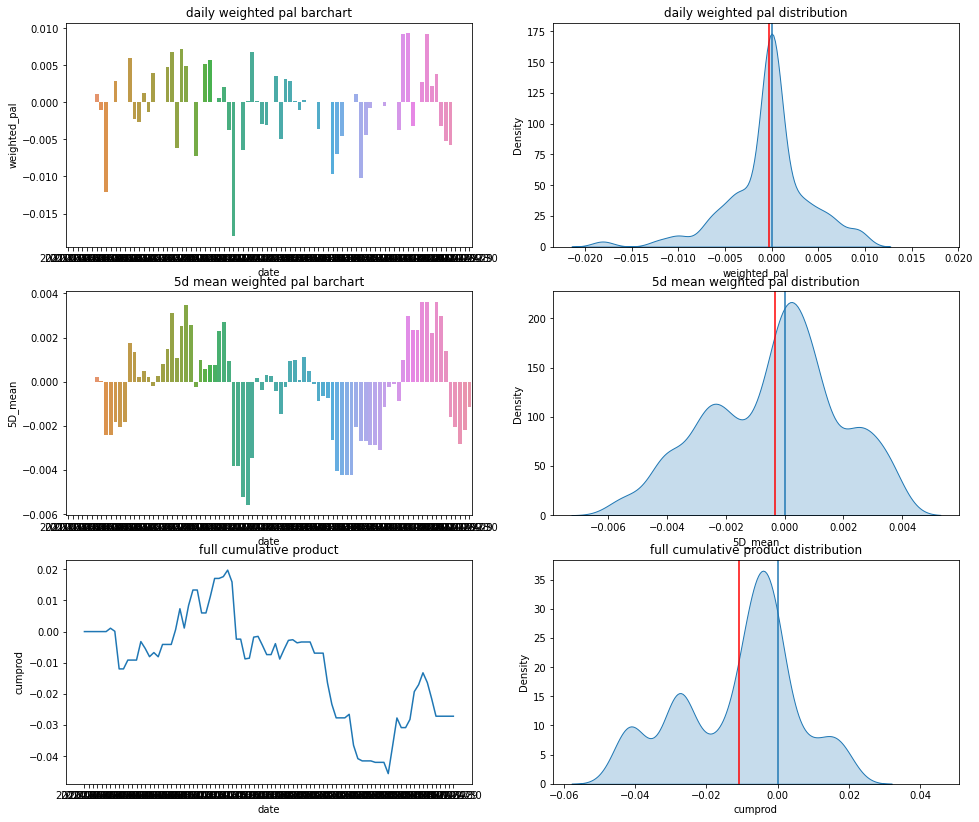

In [27]:
def GenerateLineChart(df, column, ax, title): 
    ax.set_title(title)
    sns.lineplot(data = df, x = 'date', y = column, ax = ax)

def GenerateBarChart(df, column, ax, title): 
    ax.set_title(title)
    sns.barplot(data = df, x = 'date', y = column, ax = ax)
    
def GenerateHistogram(df, column, ax, title):
    ax.set_title(title)
    data = df[column].dropna()
    sns.kdeplot(data,bw=0.25,ax=ax, fill=True)
    ax.axvline(0, 0, 1)
    color = 'green'
    if mean(data)<0:
        color = 'red'
    ax.axvline(mean(data), 0, 1, color = color)
    m = max(abs(min(data)), abs(max(data)))
    ax.axvline(-m, 0, 0)
    ax.axvline(m, 0, 0)

for a in allocators:
    res = allocator_returns[a]
    fig, axs = plt.subplots(3,2, figsize=(16,14))
    print('allocator: ' + a)
    GenerateBarChart(res, 'weighted_pal', axs[0,0], 'daily weighted pal barchart')
    GenerateHistogram(res, 'weighted_pal', axs[0,1], 'daily weighted pal distribution')
    GenerateBarChart(res, '5D_mean', axs[1,0], '5d mean weighted pal barchart')
    GenerateHistogram(res, '5D_mean', axs[1,1], '5d mean weighted pal distribution')
    res['cumprod'] = (1 + res['weighted_pal']).cumprod() - 1
    GenerateLineChart(res, 'cumprod', axs[2,0], 'full cumulative product')
    GenerateHistogram(res, 'cumprod', axs[2,1], 'full cumulative product distribution')
    plt.show()